## A Unique Way of Visualizing Confusion Matrix --- Sankey Chart
###Go Sankey for Less Confusion 

A confusion matrix in machine learning conviniently summarizes a model's performance. However, when communicating with non technical stakeholders, the confusion matrix might seem unintuitive. So what's the fix - create a Sankey diagram.

### What's a Sankey diagram in a nutshell?

A Sankey diagram is used to visualize flow or connections from source to sink. Let's undertand its applications with a simple example. 

Consider we have a dataset of enrolments in data science or business analytics courses in three universities. Here the universities can be treated as the source and the courses as the sink. The number of enrolments indicates connection from source to sink. Some of these connections can be heavier than others, eg, connection from university A to data science is heavier than its connection to business analytics.

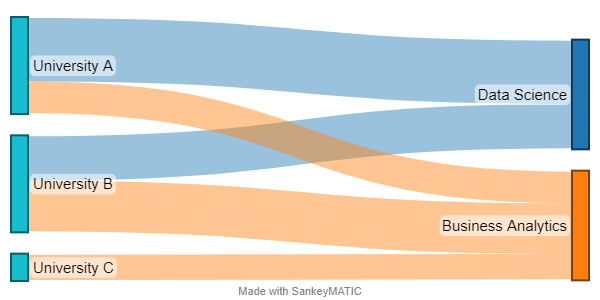

Sankey diagram for the confusion matrix has the following components:

* Source : True Classes
* Target (Sink): Predicted Classes
* Connection/flow: Number of instances

### How to create a Sankey diagram from a Confusion Matrix?

We will follow 3 steps approach as illustrated in the below image to create the Sankey diagram.

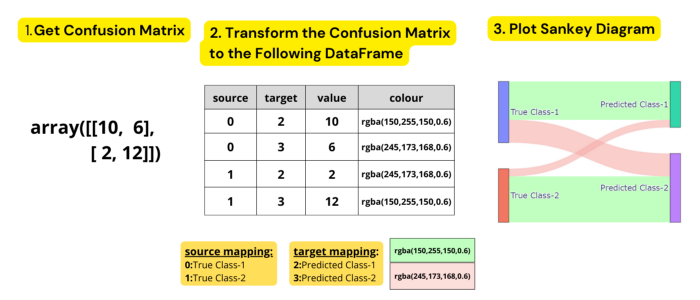

### Step 1: Get Confusion Matrix

In this step, we will generate a confusion matrix. This can be output from the scikit-learn confusion matrix function. For similicity, we will use the following confusion matrix.

In [2]:
# importing libraries
import pandas as pd
import numpy as np
from plotly import graph_objects as go
# create a confusion matrix
confusion_matrix = np.array([[10,6],[2,12]])
confusion_matrix

array([[10,  6],
       [ 2, 12]])

### Step 2: Transform Confusion Matrix to DataFrame

#### 2.1 -- Create a dataframe from confusion matrix

In [10]:
# create a dataframe
df = pd.DataFrame(data=confusion_matrix,
                  index=[f"True Class-{i+1}" for i in range(confusion_matrix.shape[0])],
                  columns = [f"Predicted Class-{i+1}" for i in range(confusion_matrix.shape[0])])
df

,Predicted Class-1,Predicted Class-2
True Class-1,10,6
True Class-2,2,12


#### 2.2 -- Restructure the dataframe

In [11]:
# restructure the dataframe
df = df.stack().reset_index()
df

,level_0,level_1,0
0,True Class-1,Predicted Class-1,10
1,True Class-1,Predicted Class-2,6
2,True Class-2,Predicted Class-1,2
3,True Class-2,Predicted Class-2,12


In [12]:
# rename the default column names
df.rename(columns={"level_0":"source", "level_1": "target", 0:"value"}, inplace=True)
df

,source,target,value
0,True Class-1,Predicted Class-1,10
1,True Class-1,Predicted Class-2,6
2,True Class-2,Predicted Class-1,2
3,True Class-2,Predicted Class-2,12


#### 2.3 -- Add a new column "color"

Now we will add a new column color to highlight the truth of predictions. Here rgba(211, 255, 216, 0.6) indicates green color, which will highlight correct **predictions**. Whereas **incorrect predictions** will be highlighted in red color which is rgba(245, 173, 168, 0.6). 

In [13]:
df['color'] = df.apply(lambda x: "rgba(211,255,216,0.6)" if x.source.split()[-1] == x.target.split()[-1] else "rgba(245, 173, 168, 0.6)", axis=1)
df

,source,target,value,color
0,True Class-1,Predicted Class-1,10,"rgba(211,255,216,0.6)"
1,True Class-1,Predicted Class-2,6,"rgba(245, 173, 168, 0.6)"
2,True Class-2,Predicted Class-1,2,"rgba(245, 173, 168, 0.6)"
3,True Class-2,Predicted Class-2,12,"rgba(211,255,216,0.6)"


#### 2.4 --- Map Source and target columns to a numeric index  

In [14]:
# Extract unique values from source and target columns
labels = pd.concat([df.source, df.target]).unique()
labels

array(['True Class-1', 'True Class-2', 'Predicted Class-1',
       'Predicted Class-2'], dtype=object)

In [15]:
# Get indices of the above unique values
labels_indices = {label:index for index, label in enumerate(labels)}
labels_indices

{'True Class-1': 0,
 'True Class-2': 1,
 'Predicted Class-1': 2,
 'Predicted Class-2': 3}

In [16]:
# map the source and target columns using the above indices
df[["source", "target"]] = df[["source", "target"]].applymap(lambda x: labels_indices[x])
df

,source,target,value,color
0,0,2,10,"rgba(211,255,216,0.6)"
1,0,3,6,"rgba(245, 173, 168, 0.6)"
2,1,2,2,"rgba(245, 173, 168, 0.6)"
3,1,3,12,"rgba(211,255,216,0.6)"


#### 2.5 -- Add New column "tooltip"

Lets add a new column for the text to show when we hover over the chart.

In [18]:
pd.set_option("max_colwidth", 100)
df["tooltip"] = df.apply(lambda x: 
                         f"{x['value']} {labels[x['target']].split()[-1]} instances correctly classified as {labels[x['target']].split()[-1]}"
                         if x['color'] == 'rgba(211,255,216,0.6)'
                         else
                         f"{x['value']} {labels[x['target']].split()[-1]} instances misclassified as {labels[x['target']].split()[-1]}", axis=1)
df

,source,target,value,color,tooltip
0,0,2,10,"rgba(211,255,216,0.6)",10 Class-1 instances correctly classified as Class-1
1,0,3,6,"rgba(245, 173, 168, 0.6)",6 Class-2 instances misclassified as Class-2
2,1,2,2,"rgba(245, 173, 168, 0.6)",2 Class-1 instances misclassified as Class-1
3,1,3,12,"rgba(211,255,216,0.6)",12 Class-2 instances correctly classified as Class-2


### Step-3 : Creation of Sankey Chart

The plotting function go.Sankey takes two main arguments -- node and link. Nodes are the classes i.e True Class 1, Predicted Class 2, etc. and the links are the connections/flow between True and Predicted Classes. 

In [19]:
# Create a Sankey chart
fig = go.Figure(data=
                [go.Sankey(
                    node = dict(
                        pad = 20,
                        thickness = 20,
                        line = dict(color="black", width=1.0),
                        label=labels,
                        # this template will be used to display text when hovering over the nodes
                        hovertemplate="%{label} has total %{value:d} instances<extra></extra>"
                    ),
                    link= dict(
                        source = df.source,
                        target = df.target,
                        value = df.value,
                        color = df.color,
                        customdata = df['tooltip'],
                        # this template will be used to display text when hovering over the links
                        hovertemplate = "%{customdata}<extra></extra>"
                    )
    
)])

fig.update_layout(title_text="Confusion Matrix Visualization Using Sankey Diagram", font_size=13, width = 510, height=450)
fig.show(render="jpg")